# The goal of this is to optimise the pathing of the van throughout the day 

The method outlined below is a greedy / heuristic method which attempts to maximise the score collection at each time bin. While taking into account

a) Cannot be in a single stop longer than 1 hour 

b) Add a penalty for travel distance 

c) Can only visit each bus stop once per day

d) Add penalty for visiting a bus stop, if later on in the day, it has a better value 


#### This represents a fairly primative route optimisation set up, and if time allowed it the following adjustments would be made 

a) Take into account the bus lines that are being captured

b) utilise OR-tools and utilise linear programming 

c) Predict optimal route for multiple days in a row, while minimising the patterning between them 

d) Take into account the number of actual buses missed during travelling

e) Take into account the starting and end location of the van (minimising travel once again from origin)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString


### Route optimisation

In [2]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = (np.sin(dlat/2)**2 +
         np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2)
    return 2 * R * np.arcsin(np.sqrt(a))

def build_lookahead_route(df, distance_penalty=0.5, max_dwell_hours=1, lookahead_hours=6):
    """
    Greedy with lookahead:
    - Cannot stay more than 1 hour
    - Stops cannot repeat
    - Penalizes visiting stops that have higher future scores
    """
    df = df.copy()
    df["Time"] = pd.to_datetime(df["Binned_time_x"])
    hourly_times = pd.date_range(df["Time"].min(), df["Time"].max(), freq="1h")
    
    visited = set()
    route = []
    prev_lat = None
    prev_lon = None
    prev_stop = None

    for t in hourly_times:
        subset = df[~df["Stop_ID"].isin(visited)].copy()
        
        if prev_stop is not None:
            # enforce max 1-hour dwell
            subset = subset[subset["Stop_ID"] != prev_stop]
        
        if subset.empty:
            route.append({
                "Time": t.time(),
                "Stop_ID": None,
                "Score": 0,
                "stop_lat": None,
                "stop_lon": None,
                "Utility": None
            })
            continue
        
        # Compute distance penalty
        if prev_lat is not None:
            subset["Dist_km"] = haversine(prev_lat, prev_lon, subset["stop_lat"], subset["stop_lon"])
        else:
            subset["Dist_km"] = 0
        
        # Compute lookahead penalty
        future_window = df[(df["Time"] > t) & (df["Time"] <= t + pd.Timedelta(hours=lookahead_hours))]
        lookahead_penalty = {}
        for stop in subset["Stop_ID"]:
            future_score = future_window[future_window["Stop_ID"] == stop]["Score"].sum()
            lookahead_penalty[stop] = future_score
        
        # Utility = immediate score - distance penalty - fraction of future score (so we avoid using high-value stops too early)
        subset["Utility"] = subset["Score"] - distance_penalty*subset["Dist_km"] - 0.4*np.array([lookahead_penalty[s] for s in subset["Stop_ID"]])
        
        # Pick best utility
        best = subset.sort_values("Utility", ascending=False).iloc[0]
        
        # Update route
        visited.add(best["Stop_ID"])
        prev_lat = best["stop_lat"]
        prev_lon = best["stop_lon"]
        prev_stop = best["Stop_ID"]
        
        route.append({
            "Time": t.time(),
            "Stop_ID": best["Stop_ID"],
            "Score": best["Score"],
            "stop_lat": prev_lat,
            "stop_lon": prev_lon,
            "Utility": best["Utility"]
        })
    
    return pd.DataFrame(route)


In [3]:
Mapping_scores = pd.read_csv("C:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/5_Predicting_future_date/Pipe3/Mapping_scores.csv")
route = build_lookahead_route(Mapping_scores, distance_penalty=0.7)
route

,Time,Stop_ID,Score,stop_lat,stop_lon,Utility
0,04:00:00,7820139-3,2.758727,58.358912,26.672439,2.758727
1,05:00:00,7820171-1,2.518837,58.356078,26.672896,2.297463
2,06:00:00,7820217-1,2.761782,58.358565,26.684149,0.634205
3,07:00:00,7820218-1,2.761364,58.358723,26.684922,0.041765
4,08:00:00,7820277-1,2.873439,58.355053,26.679570,0.209794
5,09:00:00,7820276-1,2.758727,58.355021,26.679140,0.341558
6,10:00:00,7820172-1,2.746982,58.355632,26.673914,-0.185327
7,11:00:00,7820035-1,2.633681,58.353381,26.681038,-0.412840
8,12:00:00,7820036-1,2.663263,58.353491,26.680846,-0.149949
9,13:00:00,7820037-1,0.484527,58.363475,26.677663,-0.497197


### Visualisation on tartu city map

In [20]:
from matplotlib.colors import LinearSegmentedColormap

def print_route_legend(route):
    """
    Print a simple table of visit order, stop, and time.
    """
    print("Visit | Stop_ID      | Time")
    print("----------------------------")
    for idx, row in route.dropna(subset=["Stop_ID"]).reset_index().iterrows():
        visit_order = idx + 1
        stop_id = row["Stop_ID"]
        time_str = str(row["Time"])[:5]
        print(f"{visit_order:<5} | {stop_id:<12} | {time_str}")


def save_route_legend_svg(route, filename="route_legend.svg"):
    """
    Render route overview (visit order, stop, time) as a table
    and save as high-resolution SVG.
    """

    # Build table data
    table_data = []
    for idx, row in route.dropna(subset=["Stop_ID"]).reset_index().iterrows():
        table_data.append([
            idx + 1,
            row["Stop_ID"],
            str(row["Time"])[:5]
        ])

    # Create figure
    fig, ax = plt.subplots(figsize=(6, len(table_data) * 0.4))
    ax.axis('off')

    # Make table
    table = plt.table(
        cellText=table_data,
        colLabels=["Visit", "Stop_ID", "Time"],
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    # Save as SVG
    plt.savefig("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/6_Prize_orientated_program/Pipe1/Optimal_route_legend.svg", format="svg", dpi=300)
    plt.close()

    print(f"SVG saved: {filename}")



def plot_route(route, neighborhoods_gdf):
    # Remove detached district
    neighborhoods_gdf = neighborhoods_gdf[
        neighborhoods_gdf['NIMI'] != 'Endine Tähtvere vald'
    ]
    
    # Build GeoDataFrame of stops
    gdf = gpd.GeoDataFrame(
        route.dropna(subset=["Stop_ID"]).copy(),
        geometry=[Point(xy) for xy in zip(route['stop_lon'], route['stop_lat'])],
        crs="EPSG:3301"
    ).to_crs(neighborhoods_gdf.crs)

    # Build route line
    line = LineString(gdf.geometry.tolist())
    route_line = gpd.GeoSeries([line], crs=gdf.crs)

    # Plot setup
    plt.style.use("seaborn-v0_8-white")
    fig, ax = plt.subplots(figsize=(13, 13))

    # 1. Plot neighborhoods
    neighborhoods_gdf.plot(
        ax=ax,
        facecolor="#f8f8f8",
        edgecolor="#b3b3b3",
        linewidth=0.6
    )

    # 2. Plot route line
    route_line.plot(ax=ax, color="Red", linewidth=2.5, alpha=0.9, zorder=3)
    
    cmap = LinearSegmentedColormap.from_list(
        "dodgerblue_gradient",
        ["white", "Dodgerblue"]   # or ["lightblue", "dodgerblue"] for stronger contrast
        )

    # 3. Plot stops
    gdf.plot(
        ax=ax,
        column="Score",
        cmap=cmap,
        markersize=(gdf["Score"] * 18).clip(lower=30),
        edgecolor="black",
        linewidth=0.4,
        zorder=4,
        legend=True
    )


    # 4. Annotate visit order on the map
    for idx, row in gdf.reset_index().iterrows():
        ax.annotate(
            text=str(idx + 1),
            xy=(row.geometry.x, row.geometry.y),
            xytext=(3, 3),
            textcoords="offset points",
            fontsize=9,
            fontweight='bold',
            color="black",
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7, edgecolor="white")
        )


    # Final touches
    ax.set_title(
        "Optimized Daily Enforcement Route",
        fontsize=18,
        fontweight="semibold",
        pad=16
    )
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/6_Prize_orientated_program/Pipe1/Optimal_route.svg",format='svg', bbox_inches='tight')
    plt.show()


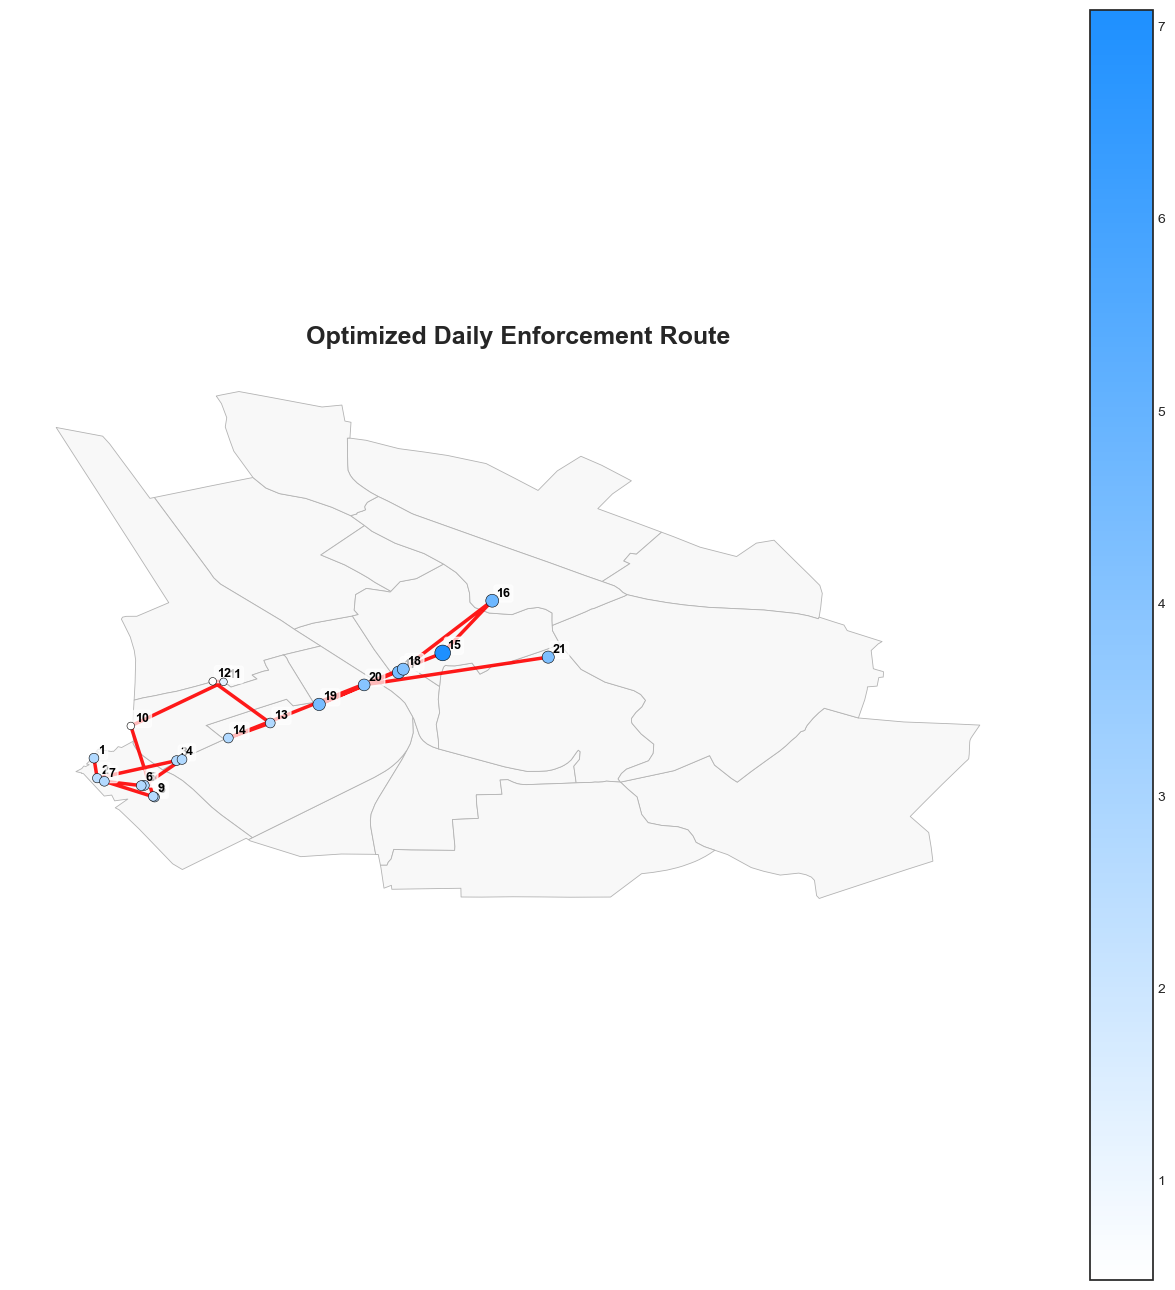

SVG saved: route_legend.svg
Visit | Stop_ID      | Time
----------------------------
1     | 7820139-3    | 04:00
2     | 7820171-1    | 05:00
3     | 7820217-1    | 06:00
4     | 7820218-1    | 07:00
5     | 7820277-1    | 08:00
6     | 7820276-1    | 09:00
7     | 7820172-1    | 10:00
8     | 7820035-1    | 11:00
9     | 7820036-1    | 12:00
10    | 7820037-1    | 13:00
11    | 7820305-1    | 14:00
12    | 7820209-1    | 15:00
13    | 7820242-1    | 16:00
14    | 7820201-1    | 17:00
15    | 7820219-1    | 18:00
16    | 7820020-1    | 19:00
17    | 7820178-1    | 20:00
18    | 7820177-1    | 21:00
19    | 7820061-1    | 22:00
20    | 7820126-1    | 23:00
21    | 7820007-1    | 00:00


In [21]:
neighborhoods_gdf = gpd.read_file("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Raw_data/Neighbourhoods/Tartu_linnaosad_wgs84.geojson")
neighborhoods_gdf = neighborhoods_gdf.to_crs("EPSG:3301")

plot_route(route, neighborhoods_gdf)
save_route_legend_svg(route)
print_route_legend(route)


